In [26]:
import torch # CUDA 12.6 version used
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [27]:
# Base Hyperparameters

batch_size = 128
epoch_num = 30
patience = 3
learning_rate = 0.001

In [28]:
# Set Device to GPU if Available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Arrange Training, Validation, and Testing Data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

all_training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_size = int(0.9 * len(all_training_data))
validation_size = len(all_training_data) - training_size
training_data, validation_data = random_split(all_training_data, [training_size, validation_size])

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [29]:
# Base Model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model_t1 = CNN()
model_t1.to(device)
crit_t1 = nn.CrossEntropyLoss()
opt_t1 = optim.Adam(model_t1.parameters(), lr=learning_rate)


In [30]:
# Task 1 Model Training and Validation

max_validation_loss = float('inf')
stop_count = 0
training_loss_values = []
validation_loss_values = []

for epoch in range(epoch_num):
    model_t1.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t1.zero_grad()
        outputs = model_t1(inputs)
        loss = crit_t1(outputs, labels)
        loss.backward()
        opt_t1.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values.append(training_loss)
            
    model_t1.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t1(validation_inputs)
            validation_loss += crit_t1(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")
    
    if validation_loss < max_validation_loss:
        max_validation_loss = validation_loss
        torch.save(model_t1.state_dict(), "cnn_model.pth")
        stop_counter = 0
    else:
        stop_counter += 1
        if stop_counter >= patience:
            break

print("done")

Epoch 1: Training Loss = 1.767, Validation Loss = 1.543
Epoch 2: Training Loss = 1.432, Validation Loss = 1.391
Epoch 3: Training Loss = 1.261, Validation Loss = 1.256
Epoch 4: Training Loss = 1.153, Validation Loss = 1.116
Epoch 5: Training Loss = 1.063, Validation Loss = 1.107
Epoch 6: Training Loss = 0.991, Validation Loss = 1.036
Epoch 7: Training Loss = 0.936, Validation Loss = 0.981
Epoch 8: Training Loss = 0.892, Validation Loss = 0.979
Epoch 9: Training Loss = 0.841, Validation Loss = 0.918
Epoch 10: Training Loss = 0.795, Validation Loss = 0.903
Epoch 11: Training Loss = 0.769, Validation Loss = 0.904
Epoch 12: Training Loss = 0.733, Validation Loss = 0.923
Epoch 13: Training Loss = 0.700, Validation Loss = 0.879
Epoch 14: Training Loss = 0.673, Validation Loss = 0.884
Epoch 15: Training Loss = 0.653, Validation Loss = 0.917
Epoch 16: Training Loss = 0.625, Validation Loss = 0.850
Epoch 17: Training Loss = 0.603, Validation Loss = 0.898
Epoch 18: Training Loss = 0.577, Validat

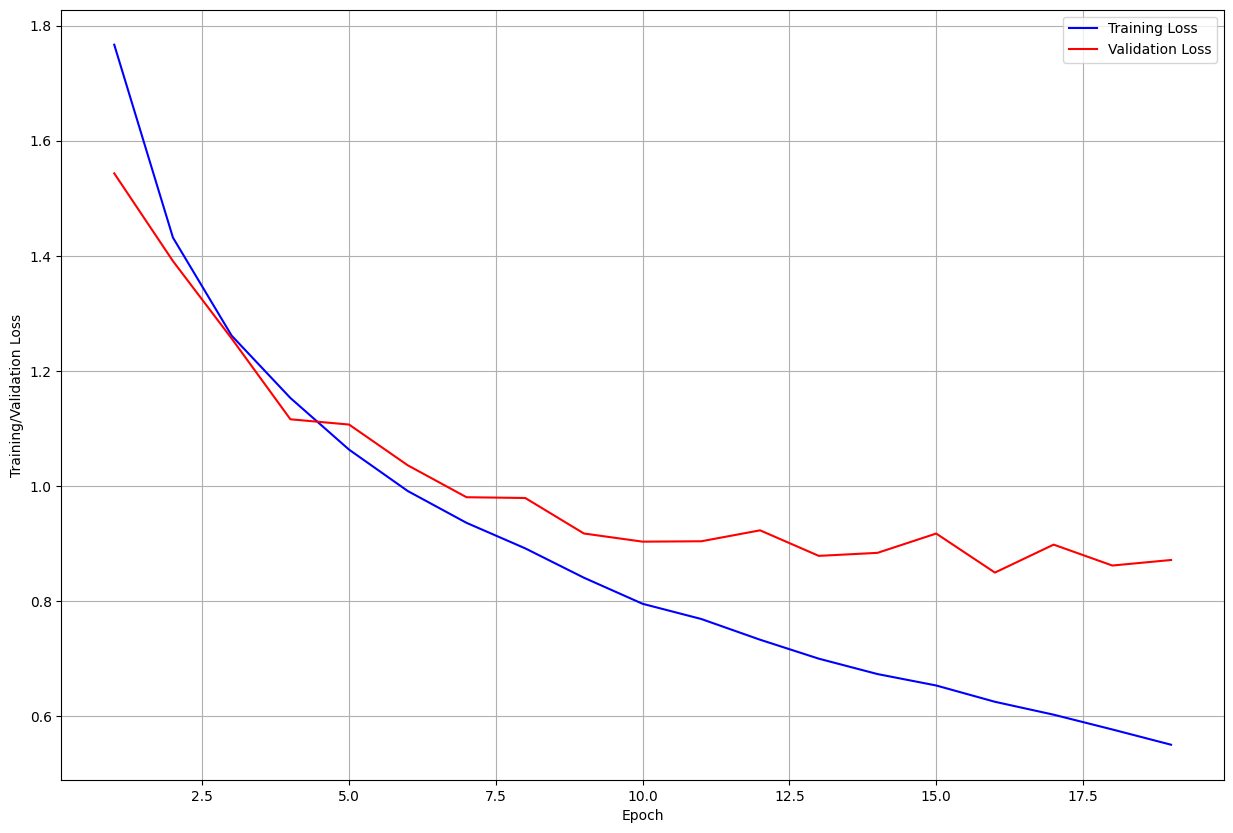

In [31]:
# Task 1 Convergence Graph

x_vals = list(range(1, len(training_loss_values)+1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, training_loss_values, color='b', label='Training Loss')
plt.plot(x_vals, validation_loss_values, color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Training/Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
# Task 2 New Hyperparameters

L2_penalty = 0.001
dropout = 0.4

In [33]:
# Task 2 Models

class CNNBasic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class CNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.dropout = nn.Dropout(p=dropout)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(func.relu(self.fc1(x)))
        x = self.dropout(func.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model_t2_basic = CNNBasic()
model_t2_basic.to(device)
crit_t2 = nn.CrossEntropyLoss()
opt_t2 = optim.Adam(model_t2_basic.parameters(), lr=learning_rate)

model_t2_reg = CNNBasic()
model_t2_reg.to(device)
opt_t2_reg = optim.Adam(model_t2_reg.parameters(), lr=learning_rate, weight_decay=L2_penalty)

model_t2_dropout = CNNDropout()
model_t2_dropout.to(device)
opt_t2_dropout = optim.Adam(model_t2_dropout.parameters(), lr=learning_rate)

In [34]:
# Task 2 Model Training and Validation - No Regularisation or Dropout

max_validation_loss_basic = float('inf')
stop_count_basic = 0
training_loss_values_basic = []
validation_loss_values_basic = []

for epoch in range(epoch_num):
    model_t2_basic.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2.zero_grad()
        outputs = model_t2_basic(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_basic.append(training_loss)
            
    model_t2_basic.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_basic(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_basic.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.757, Validation Loss = 1.533
Epoch 2: Training Loss = 1.402, Validation Loss = 1.320
Epoch 3: Training Loss = 1.240, Validation Loss = 1.225
Epoch 4: Training Loss = 1.125, Validation Loss = 1.181
Epoch 5: Training Loss = 1.037, Validation Loss = 1.031
Epoch 6: Training Loss = 0.967, Validation Loss = 1.026
Epoch 7: Training Loss = 0.905, Validation Loss = 0.978
Epoch 8: Training Loss = 0.849, Validation Loss = 0.979
Epoch 9: Training Loss = 0.806, Validation Loss = 0.927
Epoch 10: Training Loss = 0.767, Validation Loss = 0.917
Epoch 11: Training Loss = 0.730, Validation Loss = 0.913
Epoch 12: Training Loss = 0.697, Validation Loss = 0.930
Epoch 13: Training Loss = 0.674, Validation Loss = 0.867
Epoch 14: Training Loss = 0.641, Validation Loss = 0.888
Epoch 15: Training Loss = 0.616, Validation Loss = 0.864
Epoch 16: Training Loss = 0.596, Validation Loss = 0.838
Epoch 17: Training Loss = 0.563, Validation Loss = 0.893
Epoch 18: Training Loss = 0.547, Validat

In [35]:
# Task 2 Model Training and Validation - L2 Regularisation

max_validation_loss_reg = float('inf')
stop_count_reg = 0
training_loss_values_reg = []
validation_loss_values_reg = []

for epoch in range(epoch_num):
    model_t2_reg.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2_reg.zero_grad()
        outputs = model_t2_reg(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2_reg.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_reg.append(training_loss)
            
    model_t2_reg.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_reg(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_reg.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.781, Validation Loss = 1.526
Epoch 2: Training Loss = 1.438, Validation Loss = 1.339
Epoch 3: Training Loss = 1.294, Validation Loss = 1.241
Epoch 4: Training Loss = 1.188, Validation Loss = 1.181
Epoch 5: Training Loss = 1.105, Validation Loss = 1.102
Epoch 6: Training Loss = 1.043, Validation Loss = 1.050
Epoch 7: Training Loss = 0.977, Validation Loss = 1.038
Epoch 8: Training Loss = 0.929, Validation Loss = 1.031
Epoch 9: Training Loss = 0.886, Validation Loss = 0.992
Epoch 10: Training Loss = 0.839, Validation Loss = 0.938
Epoch 11: Training Loss = 0.804, Validation Loss = 0.893
Epoch 12: Training Loss = 0.771, Validation Loss = 0.875
Epoch 13: Training Loss = 0.740, Validation Loss = 0.882
Epoch 14: Training Loss = 0.714, Validation Loss = 0.871
Epoch 15: Training Loss = 0.692, Validation Loss = 0.862
Epoch 16: Training Loss = 0.664, Validation Loss = 0.831
Epoch 17: Training Loss = 0.644, Validation Loss = 0.890
Epoch 18: Training Loss = 0.632, Validat

In [36]:
# Task 2 Model Training and Validation - Dropout

max_validation_loss_dropout = float('inf')
stop_count_dropout = 0
training_loss_values_dropout = []
validation_loss_values_dropout = []

for epoch in range(epoch_num):
    model_t2_dropout.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt_t2_dropout.zero_grad()
        outputs = model_t2_dropout(inputs)
        loss = crit_t2(outputs, labels)
        loss.backward()
        opt_t2_dropout.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values_dropout.append(training_loss)
            
    model_t2_dropout.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model_t2_dropout(validation_inputs)
            validation_loss += crit_t2(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values_dropout.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")

print("done")

Epoch 1: Training Loss = 1.854, Validation Loss = 1.550
Epoch 2: Training Loss = 1.526, Validation Loss = 1.375
Epoch 3: Training Loss = 1.360, Validation Loss = 1.246
Epoch 4: Training Loss = 1.255, Validation Loss = 1.209
Epoch 5: Training Loss = 1.184, Validation Loss = 1.128
Epoch 6: Training Loss = 1.114, Validation Loss = 1.046
Epoch 7: Training Loss = 1.058, Validation Loss = 1.009
Epoch 8: Training Loss = 1.009, Validation Loss = 0.981
Epoch 9: Training Loss = 0.961, Validation Loss = 0.944
Epoch 10: Training Loss = 0.937, Validation Loss = 0.969
Epoch 11: Training Loss = 0.898, Validation Loss = 0.907
Epoch 12: Training Loss = 0.868, Validation Loss = 0.895
Epoch 13: Training Loss = 0.838, Validation Loss = 0.928
Epoch 14: Training Loss = 0.815, Validation Loss = 0.904
Epoch 15: Training Loss = 0.794, Validation Loss = 0.931
Epoch 16: Training Loss = 0.772, Validation Loss = 0.889
Epoch 17: Training Loss = 0.747, Validation Loss = 0.911
Epoch 18: Training Loss = 0.733, Validat

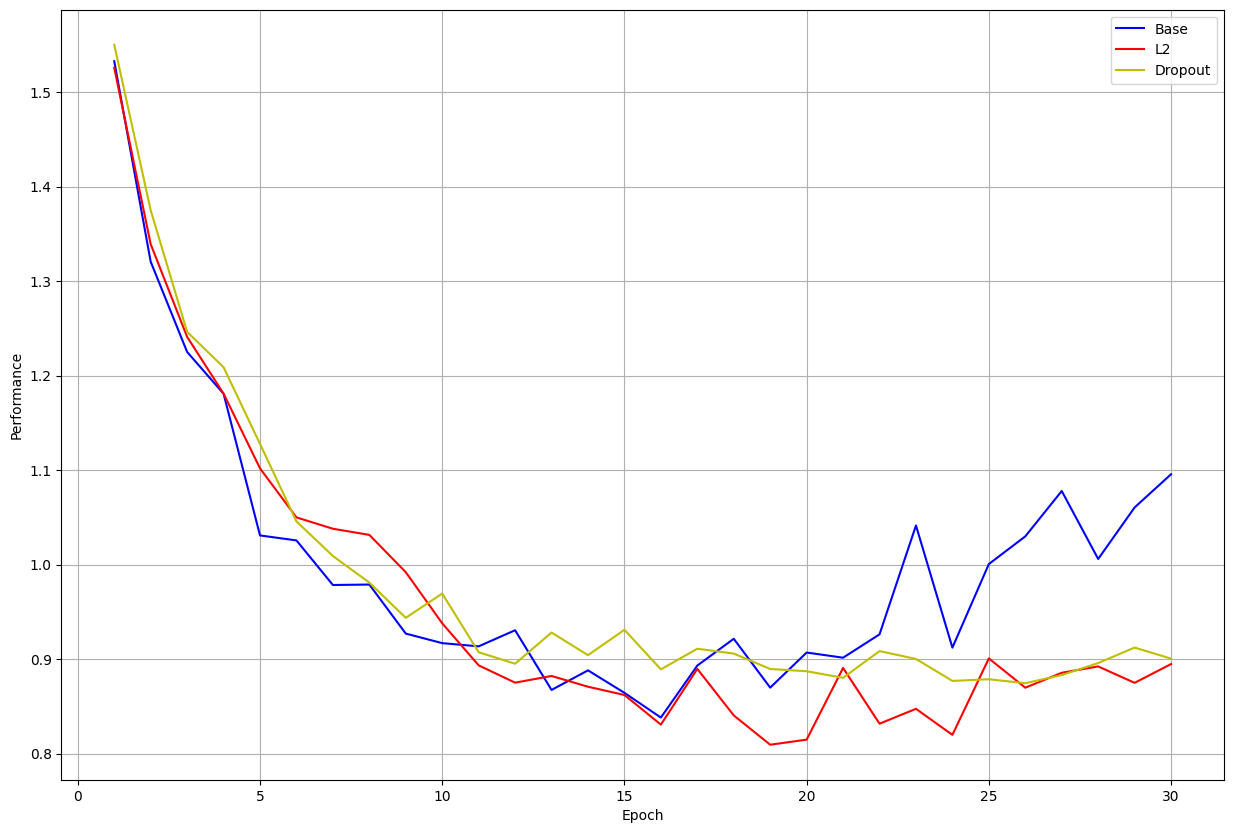

In [37]:
# Task 2 Convergence Graph

x_vals = list(range(1, epoch_num + 1))
plt.figure(figsize=(15,10))
plt.plot(x_vals, validation_loss_values_basic, color='b', label='Base')
plt.plot(x_vals, validation_loss_values_reg, color='r', label='L2')
plt.plot(x_vals, validation_loss_values_dropout, color='y', label='Dropout')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.grid(True)
plt.legend()
plt.show()